# 02 - Zeisel NIMFA

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from copy import deepcopy
from numpy import ma
from sklearn.decomposition import NMF, PCA
from sklearn.manifold import TSNE
from umap import UMAP

import nimfa as ni

In [3]:
zeisel_path = '/media/tmo/data/work/datasets/zeisel/expression_sara_filtered.txt'
zeisel_meta_path = '/media/tmo/data/work/datasets/zeisel/expression_mRNA_17-Aug-2014.txt'

In [4]:
%%time
zeisel_df = pd.read_csv(zeisel_path, sep='\t', skiprows=1, header=None, index_col=0)
zeisel_df.index.name = 'gene'

CPU times: user 4.8 s, sys: 387 ms, total: 5.19 s
Wall time: 5.19 s


In [5]:
zeisel_meta_df = pd.read_table(zeisel_meta_path, nrows=12, index_col=1, header=None)
zeisel_meta_df.drop(zeisel_meta_df.columns[0], axis=1, inplace=True)
zeisel_meta_df = zeisel_meta_df.T.reset_index()[['tissue', 'level1class', 'level2class']]
zeisel_meta_df.index.name = 'cell'

In [6]:
for meta_col in zeisel_meta_df.columns:
    zeisel_meta_df[meta_col] = zeisel_meta_df[meta_col].astype('category')

In [7]:
zeisel_meta_df.head()

1,tissue,level1class,level2class
cell,,,
0,sscortex,interneurons,Int10
1,sscortex,interneurons,Int10
2,sscortex,interneurons,Int6
3,sscortex,interneurons,Int10
4,sscortex,interneurons,Int9


In [8]:
genes = zeisel_df.index

In [9]:
zeisel_m = zeisel_df.as_matrix()

In [10]:
zeisel_m.shape

(13063, 3005)

In [11]:
def tsne_embed(X):
    return pd.DataFrame(TSNE().fit_transform(X))

---

---

# SPA selection 

In [12]:
%%time
sep_spa_fit = ni.SepNmf(zeisel_m)()

CPU times: user 32min 19s, sys: 7min 35s, total: 39min 55s
Wall time: 3min 44s


In [14]:
sep_spa_W = sep_spa_fit.basis()

In [15]:
sep_spa_H = sep_spa_fit.coef()

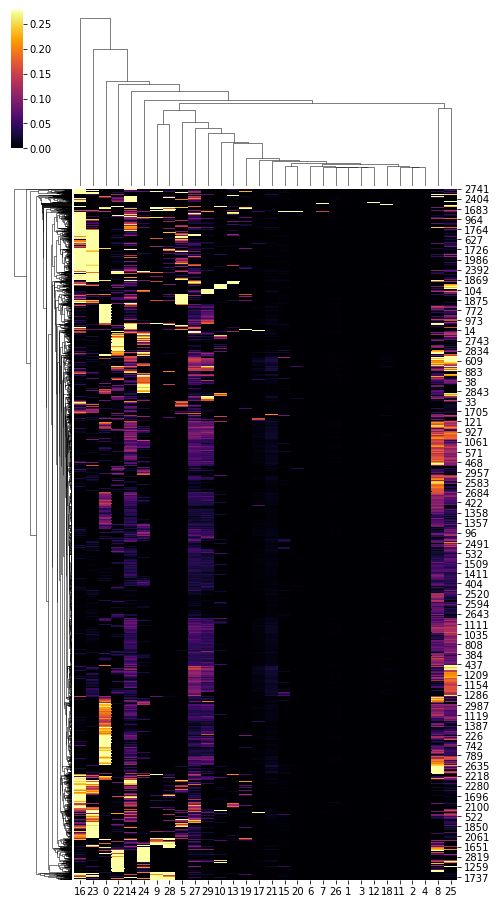

In [18]:
sns.clustermap(sep_spa_H.T,
               cmap='inferno',               
               robust=True, 
               figsize=(8, 16))
plt.show()

In [19]:
%%time
sep_spa_umap_df = pd.DataFrame(UMAP(random_state=666).fit_transform(sep_spa_H.T))

CPU times: user 23.2 s, sys: 10.1 s, total: 33.4 s
Wall time: 20.7 s


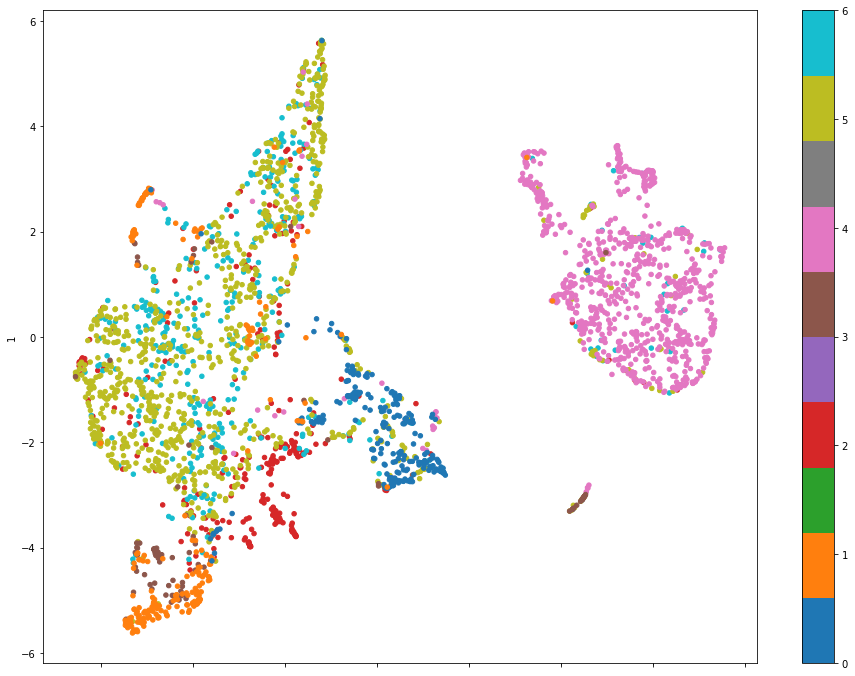

In [20]:
sep_spa_umap_df.plot.scatter(x=0, y=1, c=zeisel_meta_df['level1class'].cat.codes, cmap=plt.cm.get_cmap('tab10'), figsize=(16,12))
plt.show()

---

# SPA - structured compression

In [75]:
%%time
sep_spa_struct_fit = ni.SepNmf(zeisel_m, compression='structured', selection='spa', rank=50, seed=777)()

CPU times: user 2.01 s, sys: 1.7 s, total: 3.72 s
Wall time: 1.81 s


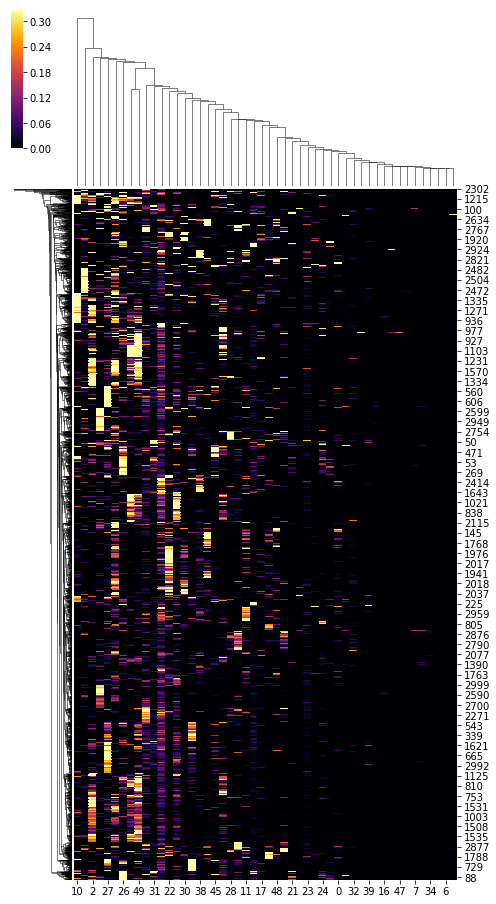

In [76]:
sns.clustermap(sep_spa_struct_fit.coef().T,
               cmap='inferno',               
               robust=True, 
               figsize=(8, 16))
plt.show()

In [77]:
%%time
sep_spa_struct_umap_df = pd.DataFrame(UMAP(random_state=666).fit_transform(sep_spa_struct_fit.coef().T))

CPU times: user 15 s, sys: 10.4 s, total: 25.3 s
Wall time: 12.4 s


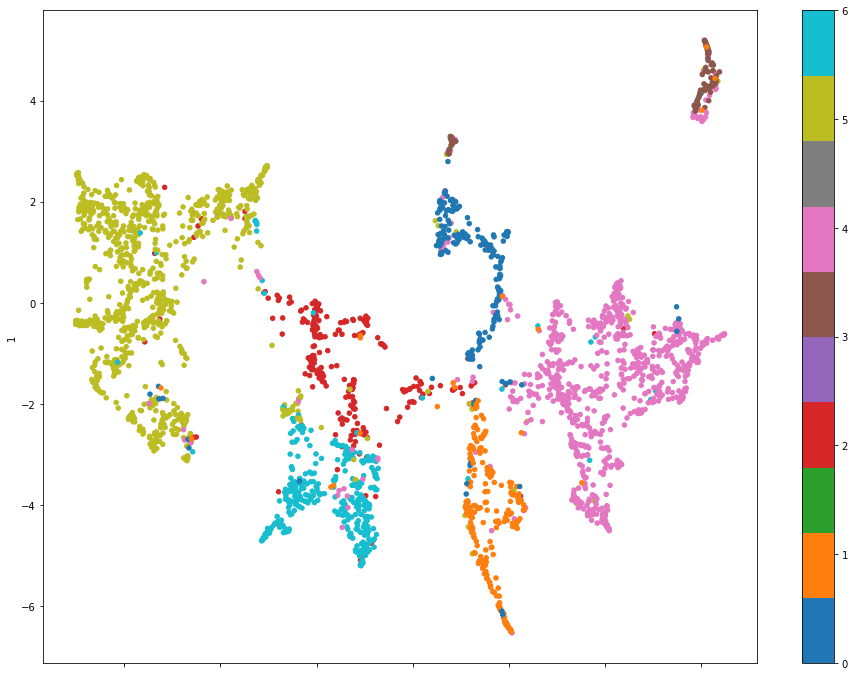

In [78]:
sep_spa_struct_umap_df.plot.scatter(x=0, y=1, c=zeisel_meta_df['level1class'].cat.codes, cmap=plt.cm.get_cmap('tab10'), figsize=(16,12))
plt.show()

In [79]:
%%time
sep_spa_struct_tsne_df = pd.DataFrame(TSNE(random_state=666).fit_transform(sep_spa_struct_fit.coef().T))

CPU times: user 1min 3s, sys: 34 s, total: 1min 37s
Wall time: 1min 37s


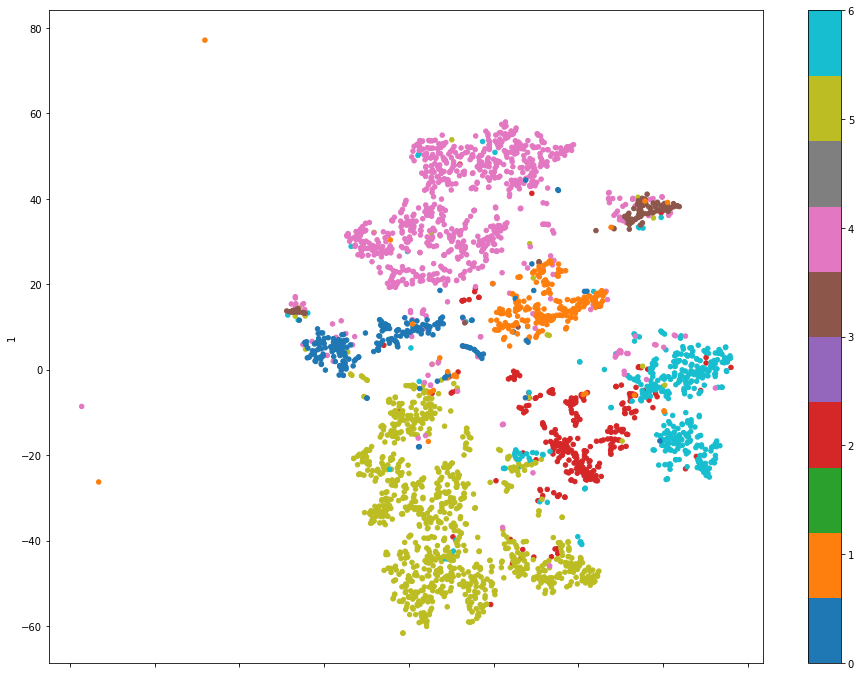

In [80]:
sep_spa_struct_tsne_df.plot.scatter(x=0, y=1, c=zeisel_meta_df['level1class'].cat.codes, cmap=plt.cm.get_cmap('tab10'), figsize=(16,12))
plt.show()

---